# CS572 Project
* We selected the paper: {}
* Based on the data and model of given paper, we are planning to make an extension of LSTM that predicts {}.

## Preparing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from sklearn.model_selection import train_test_split
import numpy as np
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import time
from matplotlib import pyplot as plt

In [1]:
data_path = 'Data' # add path

input_size = 8
hidden_size = 128
num_layers = 3
num_epochs = 2000
batch_size = 32
learning_rate = 0.001
weight_decay=0.00001

Check if your computer is prepared to run pytorch model with CUDA.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # x -> batch_size, seq, input_size
        self.fc = nn.Linear(hidden_size, 1)
        
    def makehc_zero(self, batch_size):
        self.hn = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        self.cn = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        print("clear")
        
    
    def forward(self, x):
        if self.training == True:
            # Set initial hidden and cell states 
            self.makehc_zero(x.size(0))
#         out, _ = self.rnn(x, h0)
        
        # Forward propagate LSTM
        out, (self.hn, self.cn) = self.lstm(x, (self.hn, self.cn))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        
        # Decode the hidden state of the last time step
        # out : batch_size, seq_length, hidden_size
        # out (N, 9, 128)  ???
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

Data Loading

In [5]:
data_set = []
data_path += "\Testing"
for path_idx in os.listdir(data_path):
    cur_path = os.path.join(data_path, path_idx)
    print(cur_path)
    input_file = np.loadtxt(cur_path, dtype='float', delimiter=',')
    # cell = nn.RNN(input_size=4, hidden_size=2, batchfirst=True)
    inputs = torch.Tensor(input_file)
#     print(inputs[0])
    
    inputs = inputs[:len(inputs)-len(inputs)%40]
#     labels = inputs[:, [5]]
# #     print(labels.shape)
#     labels = labels.view([-1, 40, 1])
    
    inputs = inputs[:, [1,2,3,4,6,7,8,9,5]]
    inputs = inputs.view([-1,40,9])
    
#     for test a file
    data_set += inputs
    break
   
# print(data_set)
print("load complete")

Data\Testing\190722_tension_test_space_1_trial_1.csv
load complete


In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=data_set,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=data_set,
                                          batch_size=1, 
                                          shuffle=False)
print("loader setting complete")

loader setting complete


In [11]:
# Training and Testing: To train fingertip forces from input
# data, a three-layer BT-LSTM with 128 hidden units is used.
# Sequence time length of BT-LSTM was set to T = 40. The final
# output of the BT-LSTM layer is fed into the final fully-connected
# layer to obtain the one-dimensional output. The mean squared
# error (MSE) function is used to measure the loss between the
# predicted and the ground truth contact force. During training,
# the number of epoch was 2000, and the mini batch size was 32.
# Adam optimizer was used with 0.001 learning rate and 10−5
# weight decay
lstm = LSTM(input_size, hidden_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate, weight_decay=weight_decay)

Load cell if needed

In [12]:
lstm.load_state_dict(torch.load('Playground_model.ckpt'))

<All keys matched successfully>

Train model

In [ ]:
for i, x in enumerate(train_loader):
#     print (i, x)
#     print(x.shape)
#     inputs, labels = torch.split(x, [8, 1], 2)
#     print(inputs.shape)
#     print(labels.shape)
    break

In [ ]:
for i in test_loader:
    print (i)
    break

In [ ]:
# Train the model
start = time.time()
# for epoch in range(num_epochs):
for epoch in range(1):    
    for i, inputs in enumerate(train_loader):
        inputs, labels = torch.split(inputs, [8, 1], 2)
        inputs = inputs.to(device)
        labels = labels[:,[39],:].view([-1,1])
        labels = labels.to(device)
        
        # Forward pass
        outputs = lstm(inputs)
        
#         print(labels.shape)
        
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 10 == 0:
        print ('Epoch [{}/{}], Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))
        print('time :', time.time() - start)
print("training complete")

Test model

In [13]:
lstm.eval()
start = time.time()
with torch.no_grad():
    total_labels = []
    total_outputs = []
    lstm.makehc_zero(inputs.size(0))
    for inputs in test_loader:
        inputs, labels = torch.split(inputs, [8, 1], 2)
        
        
        inputs = inputs.to(device)
        labels = labels[:, : ,:].view([-1,1])
        
        for i in range(inputs.size(1)):
            outputs = lstm(inputs[:,i,:].view([inputs.size(0),1,8]))
            total_outputs += outputs.cpu()
        
        total_labels += labels
    rmse = mean_squared_error(total_labels, total_outputs, squared = False)
    mae = mean_absolute_error(total_labels, total_outputs)

    print('Test Accuracy of the model RMSE: {}'.format(rmse))
    print('Test Accuracy of the model MAE: {}'.format(mae)) 
    print('time :', time.time() - start)

clear
Test Accuracy of the model RMSE: 5.64926815032959
Test Accuracy of the model MAE: 5.357156276702881
time : 8.67833137512207


Save model

In [ ]:
torch.save(lstm.state_dict(), 'model.ckpt')
print("save complete")

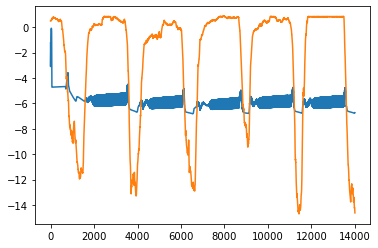

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(total_outputs)
plt.plot(total_labels)
plt.show()

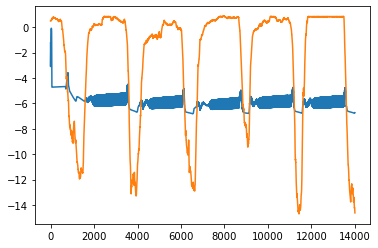

In [20]:
plt.plot(total_outputs)
plt.plot(total_labels)
plt.savefig('fig1.png')

In [ ]:
print(total_labels)